In [2]:
from ovam.stable_diffusion.daam_module import (
    StableDiffusionDAAM, StableDiffusionXLDAAM
)
import torch
from ovam import StableDiffusionHooker
from ovam.utils import set_seed
from diffusers import StableDiffusionXLPipeline, StableDiffusionPipeline
import matplotlib.pyplot as plt
import gc

In [3]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
use_sdxl = True
if use_sdxl:
    pipe = StableDiffusionXLPipeline.from_pretrained( 
        "stabilityai/stable-diffusion-xl-base-1.0",
        use_safetensors=True,
    ).to(device)
else:
    pipe = StableDiffusionPipeline.from_pretrained( 
        "runwayml/stable-diffusion-v1-5",
        use_safetensors=True,
    ).to(device)
img_size = 1024 if use_sdxl else 512
expand_size = (img_size, img_size)
hooker_kwargs = {"daam_module_class": StableDiffusionXLDAAM} if use_sdxl else {}

prompt = "A photo of a dog in the park"
guidance_scale=7.5
with StableDiffusionHooker(
            pipe, **hooker_kwargs
        ) as ovam_hooker:
    set_seed(123456)
    out = pipe(prompt=prompt, guidance_scale=guidance_scale)
    image = out.images[0]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

In [4]:
ovam_evaluator = ovam_hooker.get_ovam_callable(
    expand_size=expand_size
)
pipe = pipe.to(torch.device('cpu')) 
gc.collect()
torch.cuda.empty_cache()

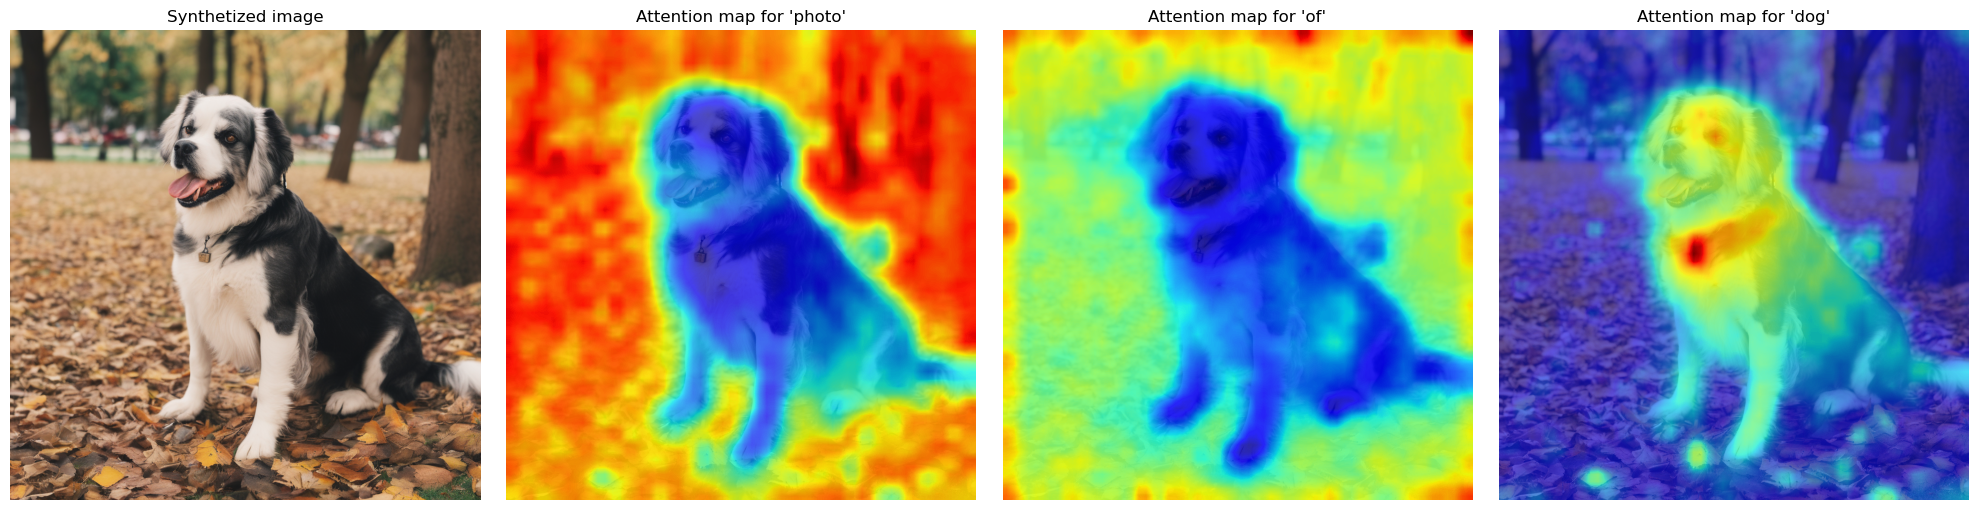

In [5]:
ovam_evaluator.to(device)
attribute_prompt = "A photo of a dog"
with torch.no_grad():
    attention_maps = ovam_evaluator(attribute_prompt)
    attention_maps = attention_maps[0].cpu().numpy() 

fig, axes = plt.subplots(1, 4, figsize=(20, 5))

for ax in axes:
    ax.axis("off")
    ax.imshow(image)

axes[0].set_title("Synthetized image")
# Tokens: 0:<SoT>, 1:A, 2:photo, 3:of, 4:a, 5:dog, 6:<EoT>
axes[1].set_title("Attention map for 'photo'")
att_1 = attention_maps[1]
axes[1].imshow(att_1, alpha=att_1 / att_1.max(), cmap='jet')
axes[2].set_title("Attention map for 'of'")
att_2 = attention_maps[3]
axes[2].imshow(att_2, alpha=att_2 / att_2.max(), cmap='jet')
axes[3].set_title("Attention map for 'dog'")
att_3 = attention_maps[6]
axes[3].imshow(att_3, alpha=att_3 / att_3.max(), cmap='jet')
# Adjust padding and save
fig.tight_layout()